In [108]:
!pip install ipywidgets > /dev/null
!jupyter nbextension enable --py widgetsnbextension

from tqdm import tqdm
from IPython.display import Image
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import os

layout=widgets.Layout(width='50%')
#Number of processes widget
num_processes_widget = widgets.IntText(
    value=0,
    description='Number of processess:',
    style= {'description_width': 'initial'},
    layout=layout
)

#Number of runs widget
num_runs_widget = widgets.IntText(
    value=0,
    description='Number of runs:',
    style= {'description_width': 'initial'},
    layout=layout
)
#Number of iterations widget
num_iterations_widget = widgets.IntText(
    value=0,
    description='Number of iterations:',
    style= {'description_width': 'initial'},
    layout=layout
)

#PnMPI Config Widget
pnmpi_conf_widget = widgets.Dropdown(
    options=[('',""),('csmpi', "csmpi.conf"), ('dumpi_csmpi', "dumpi_csmpi.conf"), ('dumpi_ninja', "dumpi_ninja.conf"), ('dumpi_pluto_csmpi', "dumpi_pluto_csmpi.conf"), ('dumpi', "dumpi.conf"), ('dumpi_csmpi_ninja', "dumpi_csmpi_ninja.conf"), ('dumpi_pluto', "dumpi_pluto.conf"), ('empty', "empty.conf")],
    value='',
    description='PnMPI Config:',
    style= {'description_width': 'initial'},
    continious_update=True,
    layout=layout
)

#Executable Path Widget
executable_widget = widgets.Text(
    value="",
    description='Executable path:',
    style= {'description_width': 'initial'},
    layout=layout
)

#Executable args Widget
executable_args_widget = widgets.Text(
    value="",
    description='Executable args:',
    style= {'description_width': 'initial'},
    layout=layout
)

trace_widget = widgets.Button(
    description='Trace',
    style= {'description_width': 'initial'},
    layout=layout
)

gen_event_graph_widget = widgets.Button(
    description='Generate Event Graph',
    style= {'description_width': 'initial'},
    layout=layout
)

slice_extraction_widget = widgets.Button(
    description='Extract Slices',
    style= {'description_width': 'initial'},
    layout=layout
)

compute_kdts_widget = widgets.Button(
    description='Compute KDTS',
    style= {'description_width': 'initial'},
    layout=layout
)

create_visualization_widget = widgets.Button(
    description='Create Visualization',
    style= {'description_width': 'initial'},
    layout=layout
)

display_visualization_widget = widgets.Button(
    description='Display Visualization',
    style= {'description_width': 'initial'},
    layout=layout
)

param_num_processes = num_processes_widget.value
param_num_runs = num_runs_widget.value
param_num_iterations = num_iterations_widget.value
param_pnmpi_config = pnmpi_conf_widget.value
param_executable = executable_widget.value
param_executable_args = executable_args_widget.value

def listen_processess(change):
    global param_num_processes
    param_num_processes = change.new
    
def listen_runs(change):
    global param_num_runs
    param_num_runs = change.new
    
def listen_iterations(change):
    global param_num_iterations
    param_num_iterations = change.new
    
def listen_pnmpi(change):
    global param_pnmpi_config
    param_pnmpi_config = change.new

def listen_executable(change):
    global param_executable
    param_executable = change.new   
    
def listen_args(change):
    global param_executable_args
    param_executable_args = change.new  
    
def on_button_clicked(button):
#     with output:
#         print("Button clicked.")
    if button == trace_widget:
        print("Tracing...")
        clean_output_dir("/home/bbogale/results/")
        trace_execution("/ANACIN-X/apps/comm_pattern_generator/build/comm_pattern_generator", "/home/bbogale/results/message_race_msg_size_512_niters_5_ndp_0.0_0.1_1.0.json /ANACIN-X/anacin-x/config", 30, 10, "dumpi_pluto_csmpi.conf", "/home/bbogale/results")
    elif button == gen_event_graph_widget:
        print("Generating Event Graph...")
        generate_event_graph(30, 10, "dumpi_and_csmpi.json", "/home/bbogale/results/")
    elif button == slice_extraction_widget:
        print("Extracting Slices...")
        extract_slices(30, 10,  "barrier_delimited_full.json", "/home/bbogale/results/")
    elif button == compute_kdts_widget:
        print("Computing the KDTS...")
        compute_kdts(30, "barrier_delimited_full.json", "/home/bbogale/results/")
    elif button == create_visualization_widget:
        print("Creating Visualization...")
        !apptainer exec instance://anacin_jupyter_instance \
        bash -c 'cd /ANACIN-X ; python3 anacin-x/event_graph_analysis/visualization/make_message_nd_plot.py \
        /home/bbogale/results/kdts.pkl \
        message_race \
        anacin-x/event_graph_analysis/graph_kernel_policies/wlst_5iters_logical_timestamp_label.json \
        /home/bbogale/results/kdts \
        0.0 0.1 1.0'
    elif button == display_visualization_widget:
        print("got here")
        Image(filename="/home/bbogale/results//kdts.png")
        print("got here2")

        
    
num_processes_widget.observe(listen_processess, names='value')
num_runs_widget.observe(listen_runs, names='value')
num_iterations_widget.observe(listen_iterations, names='value')
pnmpi_conf_widget.observe(listen_pnmpi, names='value')
executable_widget.observe(listen_executable, names='value')
executable_args_widget.observe(listen_args, names='value')

trace_widget.on_click(on_button_clicked)
gen_event_graph_widget.on_click(on_button_clicked)
slice_extraction_widget.on_click(on_button_clicked)
compute_kdts_widget.on_click(on_button_clicked)
create_visualization_widget.on_click(on_button_clicked)
display_visualization_widget.on_click(on_button_clicked)




Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
def create_instance(home_dir, image_path):
    #!apptainer instance start -H /home/bbogale/results/ dir_anacinx/ anacin
    cmd = 'apptainer instance start -H {} {} anacin_jupyter_instance'.format(home_dir, image_path)
    #!apptainer instance start -H home_dir image_path instance_name
    !{cmd}

In [6]:
create_instance("/home/bbogale/results", "/home/bbogale/dir_anacinx")

INFO:    instance started successfully


In [4]:
def kill_instance():
    !apptainer instance stop anacin_jupyter_instance

In [5]:
kill_instance()

INFO:    Stopping anacin_jupyter_instance instance of /home/bbogale/dir_anacinx (PID=71978)


In [8]:
def clean_output_dir(output_dir):
    #implement error checking
    os.system("rm -rf {}/*".format(output_dir))

In [63]:
def trace_execution(executable_path, args, num_processes, num_runs, pnmpi_conf, output_dir):

    
    #For benchmark
    !apptainer exec instance://anacin_jupyter_instance \
    python3 /ANACIN-X/apps/comm_pattern_generator/config/json_gen.py \
    "naive_reduce" 512 5 "/home/bbogale/results/" 0.0 0.1 1.0
    
    !apptainer exec instance://anacin_jupyter_instance cp  /ANACIN-X/submodules/CSMPI/config/default_glibc.json {output_dir}
    
    for i in tqdm(range(0,int(num_runs))):
        #Create run directory
        run_dir = "{}/run_{}/".format(output_dir, str(i).rjust(3, "0"))
        !mkdir {run_dir}
        
        #Copy CSMPI config file to run directories
        !cp {output_dir}/default_glibc.json {run_dir}/

        !sed -i 's|null|'{run_dir}'|g' {run_dir}/default_glibc.json
        
        !cd {run_dir} ; mpirun -np {num_processes} apptainer exec \
        --env LD_PRELOAD=/ANACIN-X/submodules/PnMPI/build/lib/libpnmpi.so \
        --env PNMPI_LIB_PATH=/ANACIN-X/anacin-x/pnmpi/patched_libs \
        --env PNMPI_CONF=/ANACIN-X/anacin-x/pnmpi/configs/{pnmpi_conf} \
        --env CSMPI_CONFIG={run_dir}/default_glibc.json \
        instance://anacin_jupyter_instance {executable_path} {args} > /dev/null
        
   
    #Delete CSMPI conf from output dir
    !rm {output_dir}/default_glibc.json

In [10]:
def generate_event_graph(num_processess, num_runs, dumpi_config,  output_dir):
    #Come back to this later and add config selection functionality
    dumpi_to_graph_bin="/ANACIN-X/submodules/dumpi_to_graph/build/dumpi_to_graph"
    #dumpi_to_graph_config="/ANACIN-X/submodules/dumpi_to_graph/config/" + {dumpi_config}
    dumpi_to_graph_config="/ANACIN-X/submodules/dumpi_to_graph/config/"

    #dumpi_to_graph_config="/ANACIN-X/submodules/dumpi_to_graph/config/dumpi_and_csmpi.json"

    
    for i in tqdm(range(0, num_runs)):
        run_dir = "{}/run_{}/".format(output_dir, str(i).rjust(3, "0"))
        !cd {run_dir} ; \
        mpirun -np {num_processess} apptainer exec instance://anacin_jupyter_instance {dumpi_to_graph_bin} {dumpi_to_graph_config}{dumpi_config} {run_dir} > /dev/null
    
    #!mpirun -np {num_processess} {dumpi_to_graph_bin} {dumpi_to_graph_config} {run_dir}

In [11]:
def extract_slices(num_processess, num_runs, slicing_policy_config, output_dir):
    #Add functionality to select custom slicing policies
    #slicing_policy="/ANACIN-X/anacin-x/event_graph_analysis/slicing_policies/barrier_delimited_full.json"
    #slicing_policy="/ANACIN-X/anacin-x/event_graph_analysis/slicing_policies/" + {slicing_policy_config}
    slicing_policy="/ANACIN-X/anacin-x/event_graph_analysis/slicing_policies/"

    
    for i in tqdm(range(0, num_runs)):
        run_dir = "{}/run_{}/".format(output_dir, str(i).rjust(3, "0"))
        !cd {run_dir} ; mpirun -np {num_processess} \
        apptainer exec instance://anacin_jupyter_instance \
        /ANACIN-X/anacin-x/event_graph_analysis/extract_slices.py {run_dir}/"event_graph.graphml" {slicing_policy}{slicing_policy_config} -o "slices" > /dev/null

In [12]:
def compute_kdts(num_processess, slicing_policy_config, output_dir):
    #Consult Jack about this
    graph_kernel_policy = "/ANACIN-X/anacin-x/event_graph_analysis/graph_kernel_policies/wlst_5iters_logical_timestamp_label.json"
    #slicing_policy="/ANACIN-X/anacin-x/event_graph_analysis/slicing_policies/barrier_delimited_full.json"
    slicing_policy="/ANACIN-X/anacin-x/event_graph_analysis/slicing_policies/"
    
    !cd {output_dir} ; \
    mpirun -np {num_processess} apptainer exec instance://anacin_jupyter_instance \
    /ANACIN-X/anacin-x/event_graph_analysis/compute_kernel_distance_time_series.py \
    {output_dir} {graph_kernel_policy} --slicing_policy {slicing_policy}{slicing_policy_config} -o "kdts.pkl" --slice_dir_name {output_dir}/"slices" -c > /dev/null

In [64]:
def create_graph(output_dir):
    #Consult Jack, this is something that definetly needs to be fixed
    exec_dir = "/ANACIN-X/anacin-x/event_graph_analysis/"
    kdts_path = output_dir + "/kdts.pkl"

    !apptainer exec instance://anacin_jupyter_instance \
    python3 {exec_dir}/visualization/visualize_kernel_distance_time_series.py {kdts_path} --plot_type=box -o {output_dir} 
    
    #Image(filename=output_dir+"/kdts.png")
    
    
    

### Demonstration
- We will follow each step of the execution process:
    1. Trace execution
    2. Event graph generation
    3. Slice extraction
    2. Visualization

#### Raw Executation

In [15]:
clean_output_dir("/home/bbogale/results/")

In [19]:
trace_execution("/ANACIN-X/apps/comm_pattern_generator/build/comm_pattern_generator", "/home/bbogale/results/message_race_msg_size_512_niters_5_ndp_0.0_0.1_1.0.json /ANACIN-X/anacin-x/config", 30, 10, "dumpi_pluto_csmpi.conf", "/home/bbogale/results")

100%|████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.99s/it]


In [20]:
generate_event_graph(30, 10, "dumpi_and_csmpi.json", "/home/bbogale/results/")

100%|████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.69s/it]


In [21]:
extract_slices(30, 10,  "barrier_delimited_full.json", "/home/bbogale/results/")

100%|████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.53s/it]


In [22]:
compute_kdts(30, "barrier_delimited_full.json", "/home/bbogale/results/")

In [70]:
!apptainer exec instance://anacin_jupyter_instance \
bash -c 'cd /ANACIN-X ; python3 anacin-x/event_graph_analysis/visualization/make_message_nd_plot.py \
/home/bbogale/results/kdts.pkl \
message_race \
anacin-x/event_graph_analysis/graph_kernel_policies/wlst_5iters_logical_timestamp_label.json \
/home/bbogale/results/kdts \
0.0 0.1 1.0'

Your Pearson's r value     = 0.5

It's corresponding p value = 1.1603165014108233e-32



Your Spearman's ρ value    = 0.5

It's corresponding p value = 1.4582369623774334e-32



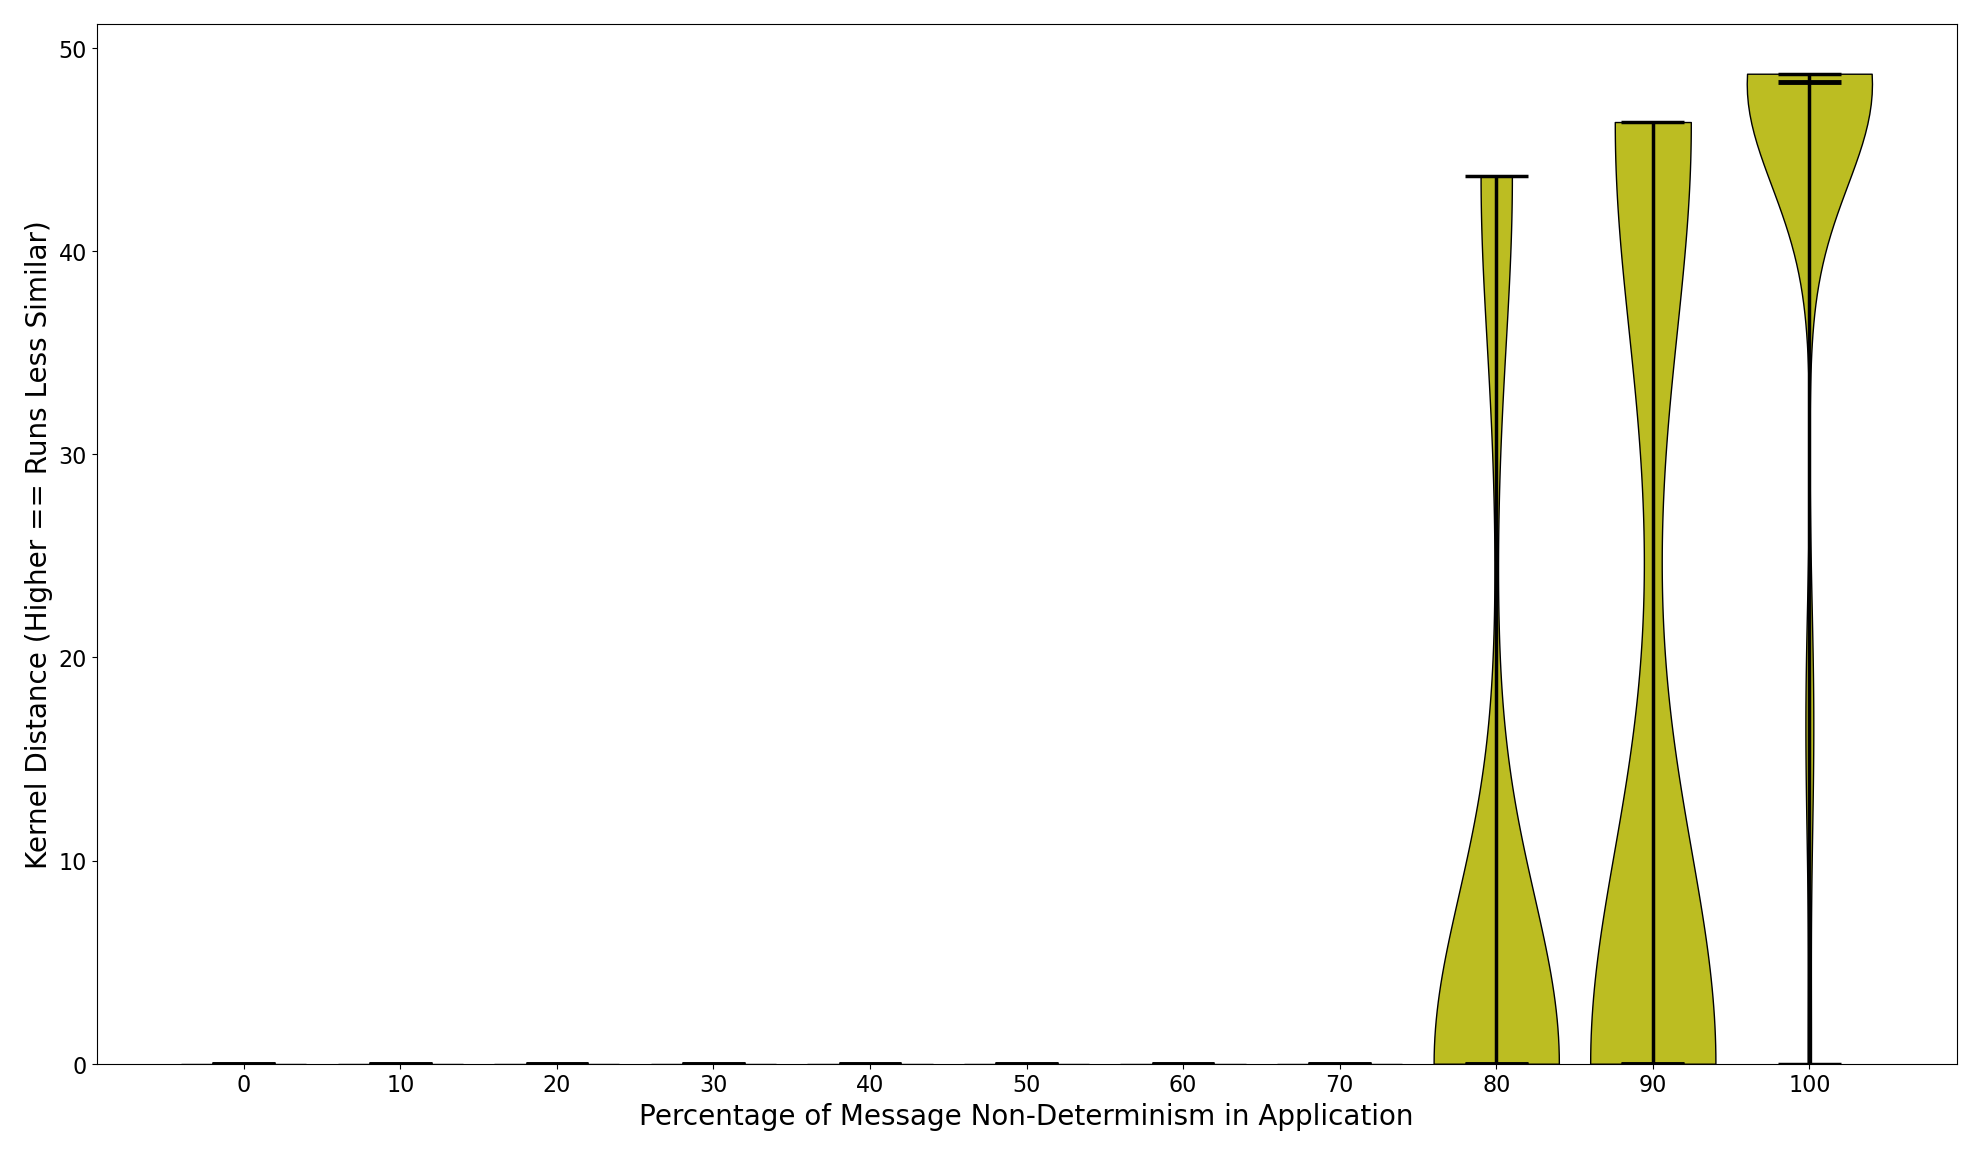

In [96]:
Image(filename="/home/bbogale/results//kdts.png")

### Parameters

In [23]:
display(num_processes_widget, num_runs_widget, num_iterations_widget, pnmpi_conf_widget, executable_widget, executable_args_widget)

IntText(value=0, description='Number of processess:', layout=Layout(width='50%'), style=DescriptionStyle(descr…

IntText(value=0, description='Number of runs:', layout=Layout(width='50%'), style=DescriptionStyle(description…

IntText(value=0, description='Number of iterations:', layout=Layout(width='50%'), style=DescriptionStyle(descr…

Dropdown(description='PnMPI Config:', layout=Layout(width='50%'), options=(('', ''), ('csmpi', 'csmpi.conf'), …

Text(value='', description='Executable path:', layout=Layout(width='50%'), style=DescriptionStyle(description_…

Text(value='', description='Executable args:', layout=Layout(width='50%'), style=DescriptionStyle(description_…

In [17]:
print(param_num_processes)
print(param_num_runs)
print(param_num_iterations)
print(param_pnmpi_config)
print(param_executable)
print(param_executable_args)

32
10
1
dumpi_pluto_csmpi.conf




### Execution

In [101]:
display(trace_widget)

Button(description='Trace', layout=Layout(width='50%'), style=ButtonStyle())

Tracing...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.93s/it]


In [102]:
display(gen_event_graph_widget)

Button(description='Generate Event Graph', layout=Layout(width='50%'), style=ButtonStyle())

Generating Event Graph...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.77s/it]


In [103]:
display(slice_extraction_widget)

Button(description='Extract Slices', layout=Layout(width='50%'), style=ButtonStyle())

Extracting Slices...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.60s/it]


In [104]:
display(compute_kdts_widget)

Button(description='Compute KDTS', layout=Layout(width='50%'), style=ButtonStyle())

Computing the KDTS...


In [105]:
display(create_visualization_widget)

Button(description='Create Visualization', layout=Layout(width='50%'), style=ButtonStyle())

Creating Visualization...
Your Pearson's r value     = 0.55

It's corresponding p value = 3.450023667317651e-41



Your Spearman's ρ value    = 0.55

It's corresponding p value = 2.5730393058061554e-41



### Visualization

In [109]:
display(display_visualization_widget)

Button(description='Display Visualization', layout=Layout(width='50%'), style=ButtonStyle())

got here
got here2


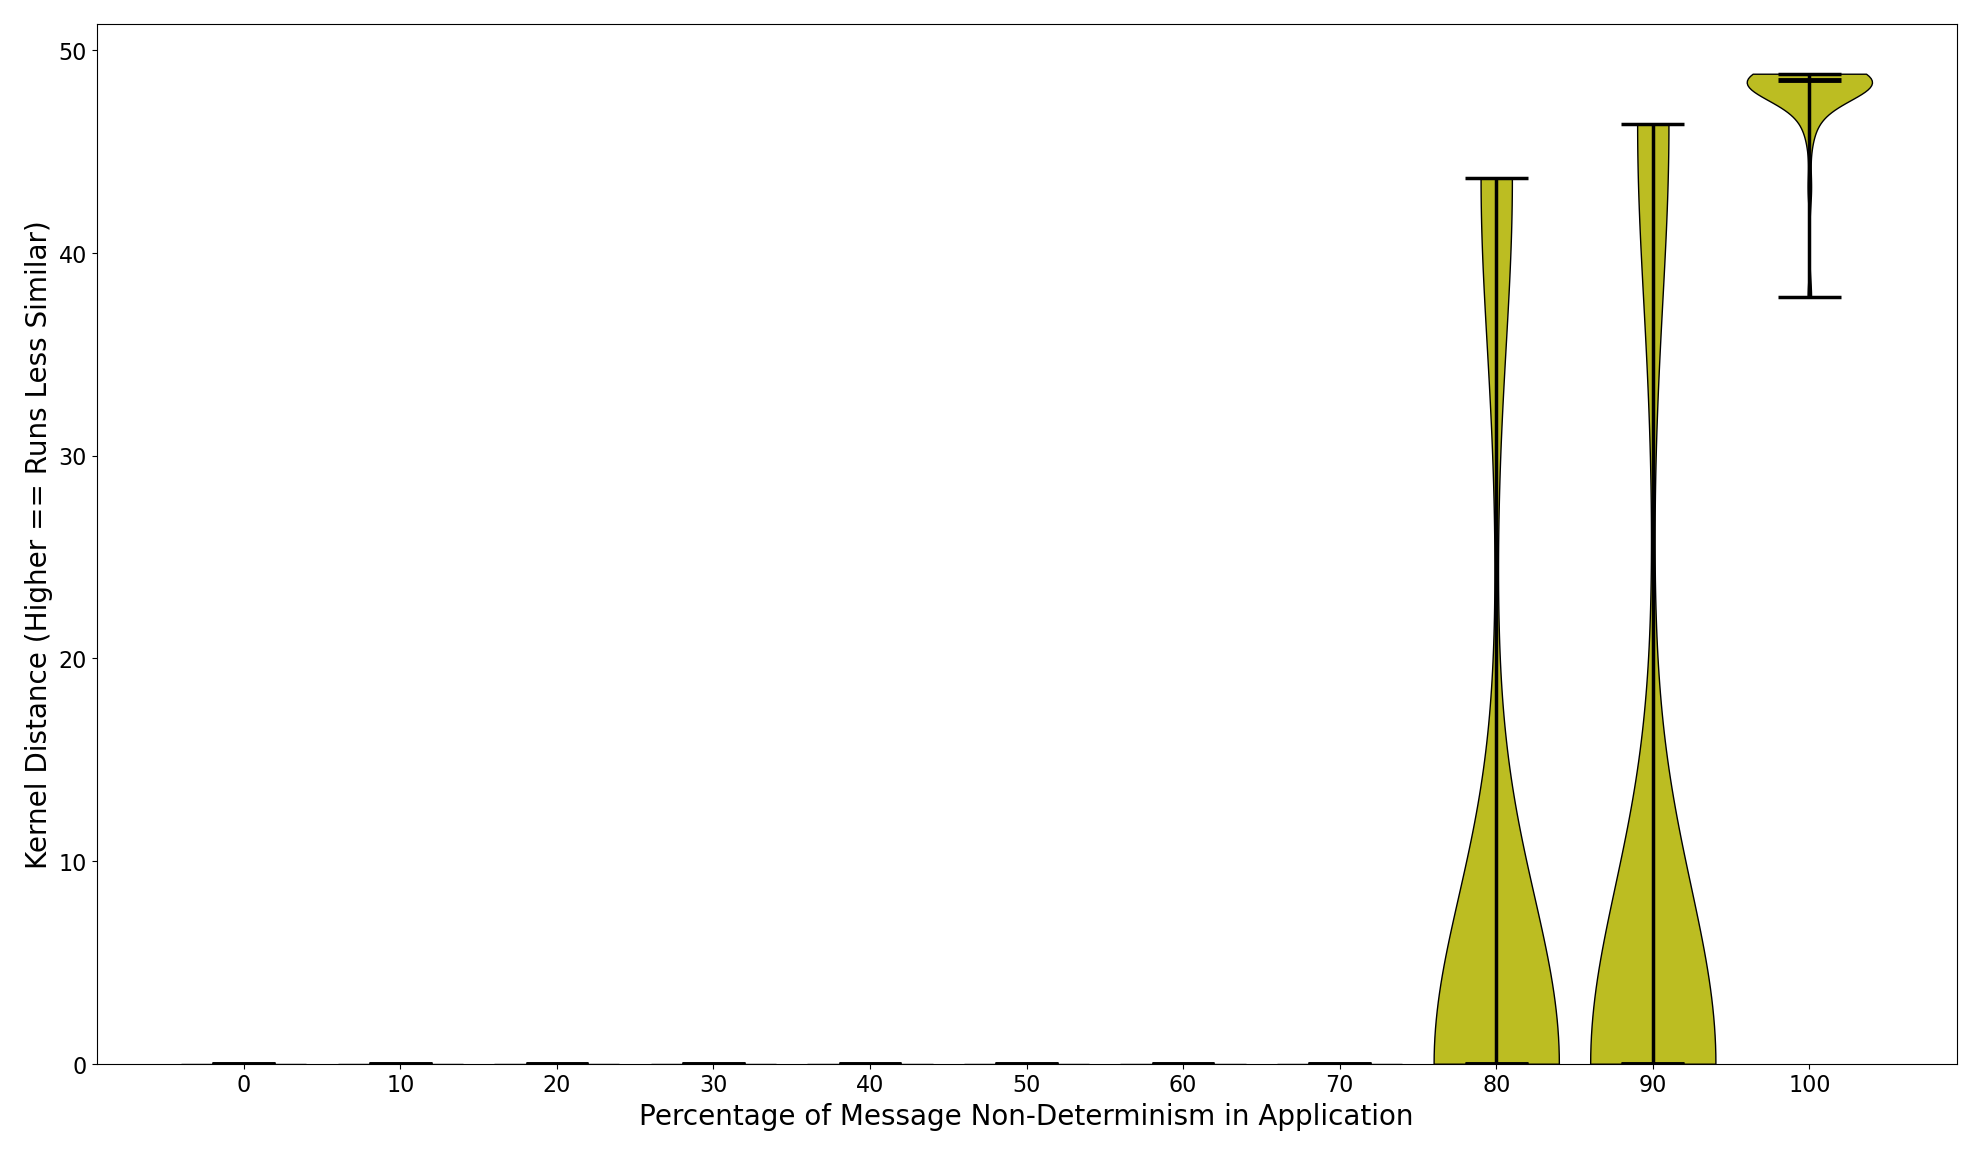

In [107]:
Image(filename="/home/bbogale/results//kdts.png")